# Практическая работа 14

## Задание 1

Загрузить датасет `breast-cancer-wisconsin1.data`.

In [1]:
import pandas as pd

data = pd.read_csv('breast-cancer-wisconsin1.data', header=None)
data

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       699 non-null    int64
 1   1       699 non-null    int64
 2   2       699 non-null    int64
 3   3       699 non-null    int64
 4   4       699 non-null    int64
 5   5       699 non-null    int64
 6   6       699 non-null    int64
 7   7       699 non-null    int64
 8   8       699 non-null    int64
 9   9       699 non-null    int64
 10  10      699 non-null    int64
dtypes: int64(11)
memory usage: 60.2 KB


In [3]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## Задание 2

Реализовать выделение признаков для классификации набора данных `breast-cancer-wisconsin1.data` по примеру, приведенному в задании.

Для начала напишем алгоритм классификации с использованием решающего дерева:

In [4]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

Features = tuple[bool, bool, bool, bool, bool, bool, bool, bool, bool, bool] | list[int]


class BreastCancer:
    def __init__(self, random_state: int = 42, n_splits: int = 5):
        self.random_state = random_state
        self.X = data.iloc[:, 0:10]
        self.y = data.iloc[:, 10]
        self.kfold = model_selection.KFold(n_splits=n_splits,
                                           random_state=random_state,
                                           shuffle=True)
        self.classifier = DecisionTreeClassifier(random_state=random_state)

    def __len__(self):
        return self.X.shape[1]

    def mean_accuracy(self, features: Features):
        exclude_indices = [i for i, n in enumerate(features) if not n]
        # noinspection PyPep8Naming
        current_X = self.X.drop(self.X.columns[exclude_indices], axis=1)

        cv_results = model_selection.cross_val_score(self.classifier,
                                                     current_X, self.y,
                                                     cv=self.kfold,
                                                     scoring='accuracy',
                                                     error_score='raise')
        return cv_results.mean()

Покажем верность классификатора при использовании всех признаков:

In [5]:
breast_cancer = BreastCancer()
all_features = (1,) * len(breast_cancer)
print(f'Выделены все признаки: {all_features}, '
      f'верность: {breast_cancer.mean_accuracy(all_features)}')

Выделены все признаки: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1), верность: 0.9327749229188079


Затем напишем алгоритм классификации с использованием генетического алгоритма:

In [6]:
import random

population_size = 50
p_crossover = 0.9
p_mutation = 0.3
max_generations = 50
hall_of_fame_size = 5
feature_penalty_factor = 0.001

random_state = 42
random.seed(random_state)

breast_cancer = BreastCancer(random_state=random_state)

In [7]:
from deap import base, creator, tools

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('zeroOrOne', random.randint, 0, 1)
toolbox.register('individualCreator', tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(breast_cancer))
toolbox.register('populationCreator', tools.initRepeat, list, toolbox.individualCreator)


def classification_accuracy(individual: Features) -> tuple[float]:
    num_features_used = sum(individual)
    if num_features_used == 0:
        return 0.0,
    else:
        accuracy = breast_cancer.mean_accuracy(individual)
        return accuracy - feature_penalty_factor * num_features_used,


toolbox.register('evaluate', classification_accuracy)
toolbox.register('select', tools.selTournament, tournsize=2)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=1.0 / len(breast_cancer))

Перед получением результатов работы алгоритма определим функцию эволюционного алгоритма:

In [8]:
from deap import tools, algorithms


# noinspection PyPep8Naming, PyShadowingNames
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
                        halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

Покажем его верность с различным количеством признаков:

In [9]:
import numpy as np

population = toolbox.populationCreator(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('max', np.max)
stats.register('avg', np.mean)
hall_of_fame = tools.HallOfFame(hall_of_fame_size)
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=p_crossover,
                                          mutpb=p_mutation, ngen=max_generations,
                                          stats=stats, halloffame=hall_of_fame,
                                          verbose=False)

In [10]:
print("- Лучшие решения:")
for idx in range(hall_of_fame_size):
    items = hall_of_fame.items[idx]
    print(f'{idx}: {items}, '
          f'приспособленность = {items.fitness.values[0]}, '
          f'верность = {breast_cancer.mean_accuracy(items)}, '
          f'признаков = {sum(items)}')

- Лучшие решения:
0: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0], приспособленность = 0.9479280575539568, верность = 0.9499280575539568, признаков = 2
1: [0, 0, 0, 1, 0, 1, 1, 1, 0, 1], приспособленность = 0.9477749229188078, верность = 0.9527749229188078, признаков = 5
2: [0, 0, 0, 1, 0, 1, 1, 0, 0, 1], приспособленность = 0.9473566289825283, верность = 0.9513566289825283, признаков = 4
3: [0, 0, 0, 1, 1, 0, 1, 1, 0, 0], приспособленность = 0.9473463514902364, верность = 0.9513463514902364, признаков = 4
4: [0, 1, 1, 0, 0, 0, 1, 0, 0, 0], приспособленность = 0.9455200411099692, верность = 0.9485200411099692, признаков = 3


<IPython.core.display.Javascript object>


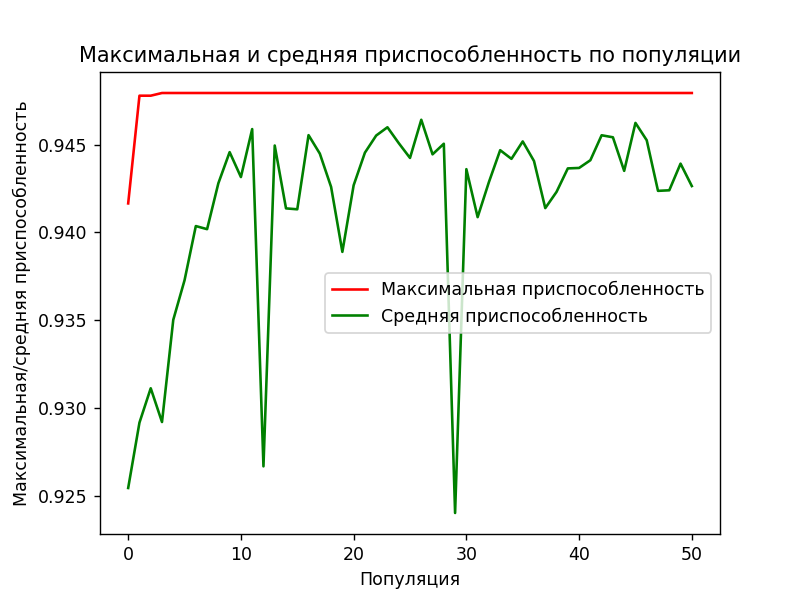

In [11]:
import matplotlib.pyplot as plt

%matplotlib notebook

maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

fig, ax = plt.subplots()
ax.plot(maxFitnessValues, color='red', label='Максимальная приспособленность')
ax.plot(meanFitnessValues, color='green', label='Средняя приспособленность')
ax.legend()
plt.xlabel('Популяция')
plt.ylabel('Максимальная/средняя приспособленность')
plt.title('Максимальная и средняя приспособленность по популяции')
fig.show()

## Задание 3

Вывести лучшее решение и на сколько увеличилось значение верности.

In [13]:
best_item = hall_of_fame.items[0]
print(f'Лучшее решение: {best_item}',
      f'Приспособленность = {best_item.fitness.values[0]}',
      f'Верность = {breast_cancer.mean_accuracy(best_item)}',
      f'Признаков = {sum(best_item)}', sep='\n')

Лучшее решение: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Приспособленность = 0.9479280575539568
Верность = 0.9499280575539568
Признаков = 2


Таким образом, применив генетический алгоритм в выборе признаков для классификации, удалось очень сильно снизить размерность задачи (с 10 признаков до 2-х),
а также повысить верность модели на 2 процента: с 93% до 95%.